https://archive.stsci.edu/missions-and-data/hsla/hsla-target-tables

In [1]:
import os
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt

# Path to your folder
data_folder = "GALAXY_DWARF_COMPACT_COS_new"

# List all files
files = os.listdir(data_folder)
print(f"Files in folder ({len(files)}):")
for f in files:
    print(f)

# If there are FITS files, let's inspect the first one
fits_files = [f for f in files if f.endswith(".fits")]
if fits_files:
    first_fits = os.path.join(data_folder, fits_files[0])
    print(f"\nReading FITS file: {first_fits}")
    
    with fits.open(first_fits) as hdul:
        hdul.info()
        data = hdul[1].data if len(hdul) > 1 else hdul[0].data
        print(f"Data type: {type(data)}")
        
        # If it's a table, convert to Astropy Table
        if isinstance(data, fits.FITS_rec):
            table = Table(data)
            print(table.columns)
            print(table[:5])  # show first 5 rows

# Optional: Basic plot example (if table has 'RA' and 'DEC')
if 'table' in locals() and 'RA' in table.colnames and 'DEC' in table.colnames:
    plt.scatter(table['RA'], table['DEC'], s=5, alpha=0.5)
    plt.xlabel('RA (deg)')
    plt.ylabel('DEC (deg)')
    plt.title('Positions of objects')
    plt.gca().invert_xaxis()  # Astronomy convention
    plt.show()


Files in folder (112):
GP1244+0216
GP1543+3446
GP0749+3337
LEDA-68454
J100348
MRK-5
UGC-5340-1
HARO3
GP0339-0725
GALAXY_DWARF_COMPACT_COS_new.list
SDSSJ095137
GP1514+3852
UGCA-116
SDSSJ082555
SDSSJ122622
SCHG-1214-277-COSPOINT
2MASX-J17402482+4743586
NGC-1140
J021307
GP0927+1740
MRK-36
GP0805+0925
GP1424+4217
SDSSJ120122
MRK-727
J015809
J1333+6246
GP1440+4619
J144805
GP1009+2916
GP1133+6514
GP1205+2620
NGC-1705
MRK-589
SBS1533+574
J1152+3400
J173501
GP1137+3524
SDSSJ1156+5008--CLUSTER
J120016
I-ZW-18-SE
GP0747+2336
NGC-4861
SDSS-J145735.13+223201.8
SDSSJ122436
GP0917+3152
MRK-1450
SDSS-J081552.00+215623.6
SDSSJ115441
J132853
J080841
J120202
GP0822+2241
GP0303-0759
GP1018+4106
GP1559+0841
J094718
J104654
UGC-12011
MRK-829
J230210
J132347
SDSSJ085103
J1044+6303
SDSSJ124827
GP1054+5238
J150934
J171236
J025346
J160810
J223831
GP1122+6154
J113116
IC-1586
GP1249+1234
J024052
NGC-7673
GP1219+1526
MRK-153
GP0751+1638
SDSSJ025426
J084956
J092055
SDSSJ141454
J121402
J093006
J095430
J133538
SDSSJ

In [2]:
import os

data_folder = "GALAXY_DWARF_COMPACT_COS_new"
galaxy_name = "GP1244+0216"  # example
galaxy_folder = os.path.join(data_folder, galaxy_name)

print(f"Contents of {galaxy_name}:")
print(os.listdir(galaxy_folder))


Contents of GP1244+0216:
['GP1244+0216_12928_1600_lbyo02piq.png', 'GP1244+0216_coadd_G160M_final_lp2.fits.gz', 'fuv_exptime_fppos_histogram.png', 'alias.txt', 'lbyo02qkq_x1d.fits', 'lbyo02pbq_x1d.fits', 'GP1244+0216_12928_1600_lbyo02q1q.png', 'all_exposures.txt', 'GP1244+0216_coadd_G130M_final_lp12.fits.gz', 'lbyo02piq_x1d.fits', 'lbyo02p4q_x1d.fits', 'fuv_exptime_histogram.png', 'GP1244+0216_coadd_G160M_final_lpALL.fits.gz', 'GP1244+0216_12928_1600_lbyo02qkq.png', 'GP1244+0216_coadd_FUVM_final_lp12.fits.gz', 'GP1244+0216_coadd_G130M_final_lp2.fits.gz', 'GP1244+0216_coadd_G130M_final_lpALL.fits.gz', 'GP1244+0216_12928_1327_lbyo02pbq.png', 'all_exposures.html', 'lbyo02r1q_x1d.fits', 'lbyo02q1q_x1d.fits', 'GP1244+0216_12928_1600_lbyo02r1q.png', 'GP1244+0216_coadd_FUVM_final_all.png', 'lbyo02oiq_x1d.fits', 'GP1244+0216_12928_1327_lbyo02oiq.png', 'GP1244+0216_12928_1327_lbyo02p4q.png', 'fuv_lifetime_position_histogram.png', 'GP1244+0216_12928_1327_lbyo02omq.png', 'GP1244+0216_coadd_FUVM_fi

In [14]:
#!/usr/bin/env python3
"""
Plot COS x1d spectra from a folder organized as:
ROOT / TARGET_NAME / *_x1d.fits

Saves PNGs per plotted figure and a CSV summary.
"""
import os, glob
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.io import fits
import pandas as pd
from scipy.interpolate import interp1d

# ======= CONFIG =======
root = "GALAXY_DWARF_COMPACT_COS_new"   # relative to cwd; change to absolute if you prefer
plot_first_N_targets = 9                # number of targets to plot; set 0 to skip plotting
specific_target = None                  # e.g. "GP1244+0216" to plot only that target; None to use first N
merge_exposures = False                 # if True, produce a merged weighted-average spectrum per target
output_dir = "spectra_plots"            # where PNGs & CSV will be saved
# ======================

os.makedirs(output_dir, exist_ok=True)

# find FITS (case-insensitive)
fits_paths = glob.glob(os.path.join(root, "**", "*.[Ff][Ii][Tt][Ss]"), recursive=True)
fits_paths += glob.glob(os.path.join(root, "**", "*.[Ff][Ii][Tt]"), recursive=True)
fits_paths = sorted(set(fits_paths))
print(f"Found {len(fits_paths)} FITS files.")

# group by immediate subfolder under root
groups = defaultdict(list)
for p in fits_paths:
    parts = os.path.normpath(p).split(os.sep)
    try:
        idx = parts.index(os.path.basename(root))
        target = parts[idx+1]
    except ValueError:
        target = os.path.basename(os.path.dirname(p))
    groups[target].append(p)

# sort by number of files (desc)
counts = sorted([(t, len(files)) for t, files in groups.items()], key=lambda x: -x[1])
targets_sorted = [t for t,_ in counts]
print("Top targets by file count (top 10):")
for t,n in counts[:10]:
    print(f"  {t:25s} {n}")

# choose targets
if specific_target:
    if specific_target not in groups:
        raise RuntimeError(f"Target {specific_target!r} not found.")
    targets_to_plot = [specific_target]
else:
    if plot_first_N_targets <= 0:
        targets_to_plot = []
    else:
        targets_to_plot = targets_sorted[:plot_first_N_targets]

if len(targets_to_plot) == 0:
    print("No targets selected for plotting. Exiting.")
    raise SystemExit(0)

# helper to find wave/flux/err columns in an astropy Table
def find_cols(tbl):
    names = [c.lower() for c in tbl.colnames]
    wave_idx = None; flux_idx = None; err_idx = None
    for i,n in enumerate(names):
        if any(k in n for k in ('wave','lam','wavel','wavelength')):
            wave_idx = i
            break
    for i,n in enumerate(names):
        if any(k in n for k in ('flux','flam','f_lambda','flt')):
            flux_idx = i
            break
    for i,n in enumerate(names):
        if any(k in n for k in ('error','err','sigma','unc')):
            err_idx = i
            break
    if (wave_idx is None or flux_idx is None) and len(tbl.colnames) == 2:
        wave_idx = 0; flux_idx = 1
    return (tbl.columns[wave_idx] if wave_idx is not None else None,
            tbl.columns[flux_idx] if flux_idx is not None else None,
            tbl.columns[err_idx]  if err_idx  is not None else None)

# weighted merge function
def weighted_merge(waves_list, flux_list, err_list, dwave=0.1):
    # find overlapping common range
    wmin = max(np.nanmin(w) for w in waves_list)
    wmax = min(np.nanmax(w) for w in waves_list)
    if wmax <= wmin:
        return None, None, None
    grid = np.arange(wmin, wmax + dwave, dwave)
    num = np.zeros_like(grid)
    den = np.zeros_like(grid)
    for w,f,e in zip(waves_list, flux_list, err_list):
        if e is None:
            wgt = np.ones_like(f)
        else:
            wgt = 1.0 / (e**2 + 1e-30)
        fi = interp1d(w, f, bounds_error=False, fill_value=np.nan)(grid)
        wi = interp1d(w, wgt, bounds_error=False, fill_value=0.0)(grid)
        mask = ~np.isnan(fi) & (wi > 0)
        num[mask] += fi[mask] * wi[mask]
        den[mask] += wi[mask]
    ok = den > 0
    merged = np.full_like(grid, np.nan, dtype=float)
    merged_err = np.full_like(grid, np.nan, dtype=float)
    merged[ok] = num[ok] / den[ok]
    merged_err[ok] = np.sqrt(1.0 / den[ok])
    return grid, merged, merged_err

# iterate and plot
summary = []
for target in targets_to_plot:
    files = sorted(groups[target])
    print(f"\nTarget {target}: {len(files)} files")
    waves_all=[]; flux_all=[]; err_all=[]
    plt.figure(figsize=(8,4))
    for f in files:
        try:
            tbl = Table.read(f, format='fits')
        except Exception:
            # fallback: try to find a table HDU
            with fits.open(f) as hdul:
                tbl = None
                for h in hdul:
                    if getattr(h, 'data', None) is not None and h.data.size > 0:
                        try:
                            tbl = Table(h.data)
                            break
                        except Exception:
                            pass
                if tbl is None:
                    print("  [WARN] no table data in", f)
                    continue
        wcol, fcol, ecol = find_cols(tbl)
        if wcol is None or fcol is None:
            print("  [WARN] could not auto-detect wave/flux in", os.path.basename(f))
            continue
        wave = np.array(wcol, dtype=float); flux = np.array(fcol, dtype=float)
        err = (np.array(ecol, dtype=float) if ecol is not None else None)
        mask = (~np.isnan(wave)) & (~np.isnan(flux))
        if err is not None:
            mask &= ~np.isnan(err)
        if mask.sum() < 5:
            continue
        wave = wave[mask]; flux = flux[mask]; err = (err[mask] if err is not None else None)
        waves_all.append(wave); flux_all.append(flux); err_all.append(err)
        plt.plot(wave, flux, linewidth=0.8, label=os.path.basename(f))
        if err is not None:
            col = plt.gca().lines[-1].get_color()
            plt.fill_between(wave, flux - err, flux + err, alpha=0.2, linewidth=0, facecolor=col)
    plt.xlabel("Wavelength (Å)")
    plt.ylabel("Flux")
    plt.title(target)
    if len(plt.gca().lines) > 1:
        plt.legend(fontsize=6)
    plt.tight_layout()
    outname = os.path.join(output_dir, f"{target}_overplot.png")
    plt.savefig(outname, dpi=150)
    print("  saved", outname)
    plt.close()

    # produce merged version if requested
    merged_wave, merged_flux, merged_err = (None, None, None)
    if merge_exposures and len(waves_all) >= 1:
        merged_wave, merged_flux, merged_err = weighted_merge(waves_all, flux_all, err_all, dwave=0.1)
        if merged_wave is not None:
            plt.figure(figsize=(8,4))
            plt.plot(merged_wave, merged_flux, label="merged", linewidth=1)
            if merged_err is not None:
                plt.fill_between(merged_wave, merged_flux-merged_err, merged_flux+merged_err, alpha=0.2)
            plt.xlabel("Wavelength (Å)"); plt.ylabel("Flux"); plt.title(target + " (merged)")
            merged_out = os.path.join(output_dir, f"{target}_merged.png")
            plt.tight_layout(); plt.savefig(merged_out, dpi=150); plt.close()
            print("  saved", merged_out)

    summary.append({
        "target": target,
        "n_files": len(files),
        "min_wave": float(np.nanmin([np.nanmin(w) for w in waves_all]) if waves_all else np.nan),
        "max_wave": float(np.nanmax([np.nanmax(w) for w in waves_all]) if waves_all else np.nan),
        "median_flux": float(np.nanmedian([np.nanmedian(f) for f in flux_all]) if flux_all else np.nan)
    })

# save summary
df = pd.DataFrame(summary)
csv_out = os.path.join(output_dir, "spectra_summary.csv")
df.to_csv(csv_out, index=False)
print("\nSaved summary to", csv_out)
print("Done.")


Found 579 FITS files.
Top targets by file count (top 10):
  GP1054+5238               12
  J0925+1403                12
  J1044+6303                12
  J1152+3400                12
  J1333+6246                12
  J1442-0209                12
  J1503+3644                12
  MRK-33                    12
  J160810                   9
  GP0303-0759               8

Target GP1054+5238: 12 files


  saved spectra_plots/GP1054+5238_overplot.png

Target J0925+1403: 12 files
  saved spectra_plots/J0925+1403_overplot.png

Target J1044+6303: 12 files
  saved spectra_plots/J1044+6303_overplot.png

Target J1152+3400: 12 files
  saved spectra_plots/J1152+3400_overplot.png

Target J1333+6246: 12 files
  saved spectra_plots/J1333+6246_overplot.png

Target J1442-0209: 12 files
  saved spectra_plots/J1442-0209_overplot.png

Target J1503+3644: 12 files
  saved spectra_plots/J1503+3644_overplot.png

Target MRK-33: 12 files
  saved spectra_plots/MRK-33_overplot.png

Target J160810: 9 files
  saved spectra_plots/J160810_overplot.png

Saved summary to spectra_plots/spectra_summary.csv
Done.


In [16]:
import os, glob, re
from collections import defaultdict
from astropy.table import Table
import numpy as np
import pandas as pd
from astropy.io import fits
import unicodedata

root = "GALAXY_DWARF_COMPACT_COS_new"

# helper to clean names (remove weird characters)
def clean_name(s):
    # normalize then drop non-ascii
    t = unicodedata.normalize('NFKD', s)
    return re.sub(r'[^\x00-\x7F]', '', t).strip()

# choose candidate wavelength col heuristics
def pick_wavelength_col(tbl):
    num_cols = [c for c in tbl.colnames if np.issubdtype(tbl[c].dtype, np.number)]
    best = None
    for c in num_cols:
        arr = np.array(tbl[c], dtype=float)
        if np.all(np.isfinite(arr)) and len(arr)>4:
            mn, mx = np.nanmin(arr), np.nanmax(arr)
            # prefer monotonic and within UV-visible range
            monot = np.all(np.diff(arr) >= -1e-8) or np.all(np.diff(arr) <= 1e-8)
            if 500 < mn < 5000 and 500 < mx < 5000 and monot:
                return c
            # keep a fallback if in reasonable range but not monotonic
            if 500 < mn < 5000 and 500 < mx < 5000:
                best = c
    return best

# scan and build robust summary
fits_paths = sorted(glob.glob(os.path.join(root, "**", "*.[Ff][Ii][Tt][Ss]"), recursive=True))
groups = defaultdict(list)
for p in fits_paths:
    parts = os.path.normpath(p).split(os.sep)
    idx = parts.index(os.path.basename(root))
    groups[parts[idx+1]].append(p)

summary_rows = []
for target, files in sorted(groups.items()):
    tgt_clean = clean_name(target)
    min_w, max_w = np.nan, np.nan
    flux_meds = []
    for f in files:
        try:
            tbl = Table.read(f, format='fits')
        except Exception:
            continue
        wcol = pick_wavelength_col(tbl)
        # if not found, try columns named 'WAVELENGTH' (case-insensitive)
        if wcol is None:
            for cname in tbl.colnames:
                if 'wave' in cname.lower() or 'lam' in cname.lower():
                    wcol = cname; break
        # find flux-like col
        fcol = None
        for cname in tbl.colnames:
            if any(k in cname.lower() for k in ('flux','flam','net','f_lambda')):
                fcol = cname; break
        if wcol is None or fcol is None:
            continue
        wave = np.array(tbl[wcol], dtype=float)
        flux = np.array(tbl[fcol], dtype=float)
        mask = (~np.isnan(wave)) & (~np.isnan(flux))
        if mask.sum() < 5: continue
        mn, mx = np.nanmin(wave[mask]), np.nanmax(wave[mask])
        min_w = mn if np.isnan(min_w) else min(min_w, mn)
        max_w = mx if np.isnan(max_w) else max(max_w, mx)
        flux_meds.append(np.nanmedian(flux[mask]))
    summary_rows.append({"target": tgt_clean, "n_files": len(files), "min_wave": float(min_w), "max_wave": float(max_w), "median_flux": float(np.nanmedian(flux_meds) if flux_meds else np.nan)})

df = pd.DataFrame(summary_rows)
df.to_csv("spectra_summary_clean.csv", index=False)
print(df.head(30).to_string(index=False))


                 target  n_files    min_wave    max_wave   median_flux
2MASX-J13135774+3518527        2 1026.856969 2336.713335  1.705615e-16
2MASX-J17402482+4743586        2 1026.764828 2336.503730  0.000000e+00
            GP0303-0759        8 1124.721310 1774.804264 -2.549361e-17
            GP0339-0725        4 1421.753434 1810.699270 -4.285684e-17
            GP0747+2336        4 1374.811001 1763.463854 -3.277365e-17
            GP0749+3337        4 1421.777520 1810.729913 -3.922341e-17
            GP0751+1638        4 1421.713425 1810.648190 -4.743809e-17
            GP0805+0925        4 1374.987906 1763.690782 -3.941407e-17
            GP0822+2241        4 1375.000894 1763.707425 -3.731554e-17
            GP0911+1831        8 1124.876626 1810.491685 -3.588073e-17
            GP0917+3152        4 1421.807340 1810.767764 -3.258397e-17
            GP0927+1740        4 1421.906566 1810.894228 -3.982730e-17
            GP1009+2916        4 1386.499652 1775.225944 -3.108553e-17
      

In [17]:
# robust_spectra_inspector.py
import os, glob
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

# ====== CONFIGURE THIS ======
root = "GALAXY_DWARF_COMPACT_COS_new"   # <-- set to your folder
plot_first_N_targets = 9                # 0 => no plotting
specific_target = None                  # e.g. "GP1244+0216" or None
output_dir = "plots"                    # folder where PNGs are saved
# ============================

# Create output directory
os.makedirs(output_dir, exist_ok=True)

print("cwd:", os.getcwd())
print("root exists:", os.path.exists(root))
if not os.path.exists(root):
    raise RuntimeError(f"Root path does not exist: {root!r}. Use an absolute path or check spelling/case.")

# find all FITS files (case-insensitive)
fits_paths = glob.glob(os.path.join(root, "**", "*.[Ff][Ii][Tt][Ss]"), recursive=True)
fits_paths += glob.glob(os.path.join(root, "**", "*.[Ff][Ii][Tt]"), recursive=True)  # .fit sometimes
fits_paths = sorted(set(fits_paths))
print(f"\nFound {len(fits_paths)} FITS files.")

if len(fits_paths) == 0:
    raise SystemExit("\nNo FITS found. Exiting safely. Check your root path or extensions.")

# group by immediate subfolder under root
groups = defaultdict(list)
for p in fits_paths:
    parts = os.path.normpath(p).split(os.sep)
    try:
        idx = parts.index(os.path.basename(root))
        target = parts[idx+1]
    except ValueError:
        target = os.path.basename(os.path.dirname(p))
    groups[target].append(p)

# show counts
counts = sorted([(t, len(files)) for t, files in groups.items()], key=lambda x: -x[1])
print("\nTop targets by number of FITS:")
for t, n in counts[:30]:
    print(f"  {t:25s} {n:4d}")

# choose targets
targets_sorted = [t for t, _ in counts]
if specific_target:
    if specific_target not in groups:
        raise RuntimeError(f"specific_target {specific_target!r} not found in groups.")
    targets_to_plot = [specific_target]
else:
    targets_to_plot = targets_sorted[:plot_first_N_targets] if plot_first_N_targets > 0 else []

if len(targets_to_plot) == 0:
    print("\nNo targets selected for plotting. Exiting.")
    raise SystemExit

print("\nTargets to plot:", targets_to_plot)

# ===== Plotting logic =====
from astropy.table import Table
from astropy.io import fits

def extract_wave_flux(table):
    names = [c.lower() for c in table.colnames]
    if any("wave" in n for n in names):
        wcol = next(table.columns[i] for i, n in enumerate(names) if "wave" in n)
    elif any("lam" in n for n in names):
        wcol = next(table.columns[i] for i, n in enumerate(names) if "lam" in n)
    else:
        wcol = None

    if any(("flux" in n or "flam" in n or "f_lambda" in n) for n in names):
        fcol = next(table.columns[i] for i, n in enumerate(names)
                    if ("flux" in n or "flam" in n or "f_lambda" in n))
    else:
        fcol = None

    # fallback
    if (wcol is None or fcol is None) and len(table.colnames) == 2:
        wcol, fcol = table.columns[0], table.columns[1]

    return wcol, fcol

for target in targets_to_plot:
    files = sorted(groups[target])
    fig, ax = plt.subplots(figsize=(7, 4.5))
    plotted = False

    for fpath in files:
        try:
            tbl = Table.read(fpath, format="fits")
        except Exception:
            try:
                hd = fits.open(fpath)
                tbl = None
                for h in hd:
                    if getattr(h, "data", None) is not None and h.data.size > 0:
                        try:
                            tbl = Table(h.data)
                            break
                        except Exception:
                            pass
                if tbl is None:
                    continue
            except Exception:
                continue

        wcol, fcol = extract_wave_flux(tbl)
        if wcol is None or fcol is None:
            continue

        wave, flux = np.array(wcol), np.array(fcol)
        mask = (~np.isnan(wave)) & (~np.isnan(flux))
        if mask.sum() < 5:
            continue

        ax.plot(wave[mask], flux[mask],
                label=os.path.basename(fpath), linewidth=0.8)
        plotted = True

    if plotted:
        ax.set_title(target)
        ax.set_xlabel("Wavelength (Å)")
        ax.set_ylabel("Flux")
        # Legend outside
        ax.legend(fontsize=6, loc="upper center",
                  bbox_to_anchor=(0.5, -0.15), ncol=3)
    else:
        ax.text(0.5, 0.5, "No plottable spectra",
                ha="center", va="center")
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    outpath = os.path.join(output_dir, f"{target}.png")
    plt.savefig(outpath, dpi=200, bbox_inches="tight")
    plt.close(fig)
    print(f"Saved: {outpath}")

print("\nAll plots saved in:", os.path.abspath(output_dir))


cwd: /home/arad/Desktop
root exists: True

Found 579 FITS files.

Top targets by number of FITS:
  GP1054+5238                 12
  J0925+1403                  12
  J1044+6303                  12
  J1152+3400                  12
  J1333+6246                  12
  J1442-0209                  12
  J1503+3644                  12
  MRK-33                      12
  J160810                      9
  GP0303-0759                  8
  GP0911+1831                  8
  GP1133+6514                  8
  GP1137+3524                  8
  GP1219+1526                  8
  GP1244+0216                  8
  GP1249+1234                  8
  GP1424+4217                  8
  HARO3                        8
  HE2-10                       8
  I-ZW-18-SE                   8
  J150934                      8
  MRK-1450                     8
  MRK-153                      8
  NGC-1140                     8
  NGC-1705                     8
  NGC-4861                     8
  SBS1533+574                  8
  UGC-5340-1

Saved: plots/GP1054+5238.png
Saved: plots/J0925+1403.png
Saved: plots/J1044+6303.png
Saved: plots/J1152+3400.png
Saved: plots/J1333+6246.png
Saved: plots/J1442-0209.png
Saved: plots/J1503+3644.png
Saved: plots/MRK-33.png
Saved: plots/J160810.png

All plots saved in: /home/arad/Desktop/plots


In [18]:
# robust_spectra_inspector_plus.py
import os, glob
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.io import fits

# ====== CONFIGURE THIS ======
root = "GALAXY_DWARF_COMPACT_COS_new"   # <-- your folder with *_x1d.fits
plot_first_N_targets = 5                # how many targets to process (0=all)
specific_target = None                  # e.g. "J1503+3644" or None
output_dir = "science_products"         # where results are stored
# ============================

os.makedirs(output_dir, exist_ok=True)

# --- Locate files ---
fits_paths = glob.glob(os.path.join(root, "**", "*.[Ff][Ii][Tt][Ss]"), recursive=True)
fits_paths += glob.glob(os.path.join(root, "**", "*.[Ff][Ii][Tt]"), recursive=True)
fits_paths = sorted(set(fits_paths))
if not fits_paths:
    raise SystemExit("No FITS files found. Check root path.")

# --- Group by target ---
groups = defaultdict(list)
for p in fits_paths:
    parts = os.path.normpath(p).split(os.sep)
    try:
        idx = parts.index(os.path.basename(root))
        target = parts[idx+1]
    except ValueError:
        target = os.path.basename(os.path.dirname(p))
    groups[target].append(p)

counts = sorted([(t, len(files)) for t, files in groups.items()], key=lambda x: -x[1])
targets_sorted = [t for t, _ in counts]

if specific_target:
    if specific_target not in groups:
        raise RuntimeError(f"Target {specific_target} not found.")
    targets_to_plot = [specific_target]
else:
    targets_to_plot = targets_sorted[:plot_first_N_targets] if plot_first_N_targets > 0 else targets_sorted

print("Targets to process:", targets_to_plot)

# --- Helpers ---
def extract_wave_flux(table):
    names = [c.lower() for c in table.colnames]
    if any("wave" in n for n in names):
        wcol = next(table.columns[i] for i, n in enumerate(names) if "wave" in n)
    elif any("lam" in n for n in names):
        wcol = next(table.columns[i] for i, n in enumerate(names) if "lam" in n)
    else:
        wcol = None
    if any(("flux" in n or "flam" in n or "f_lambda" in n) for n in names):
        fcol = next(table.columns[i] for i, n in enumerate(names)
                    if ("flux" in n or "flam" in n or "f_lambda" in n))
    else:
        fcol = None
    if (wcol is None or fcol is None) and len(table.colnames) == 2:
        wcol, fcol = table.columns[0], table.columns[1]
    return wcol, fcol

# --- Processing ---
for target in targets_to_plot:
    files = sorted(groups[target])
    spectra = []

    # read all exposures
    for fpath in files:
        try:
            tbl = Table.read(fpath, format="fits")
        except Exception:
            try:
                hd = fits.open(fpath)
                tbl = None
                for h in hd:
                    if getattr(h, "data", None) is not None and h.data.size > 0:
                        try:
                            tbl = Table(h.data)
                            break
                        except Exception:
                            pass
                if tbl is None:
                    continue
            except Exception:
                continue

        wcol, fcol = extract_wave_flux(tbl)
        if wcol is None or fcol is None:
            continue

        wave, flux = np.array(wcol), np.array(fcol)
        mask = (~np.isnan(wave)) & (~np.isnan(flux))
        if mask.sum() < 5:
            continue
        spectra.append((wave[mask], flux[mask], os.path.basename(fpath)))

    if not spectra:
        print(f"⚠ No usable spectra for {target}")
        continue

    # --- Interpolate all onto common wavelength grid ---
    # use first spectrum as reference grid
    ref_wave = spectra[0][0]
    all_fluxes = []
    for wave, flux, _ in spectra:
        f_interp = np.interp(ref_wave, wave, flux, left=np.nan, right=np.nan)
        all_fluxes.append(f_interp)
    all_fluxes = np.vstack(all_fluxes)

    # --- Median stack ---
    stacked_flux = np.nanmedian(all_fluxes, axis=0)
    mean_flux   = np.nanmean(all_fluxes, axis=0)

    # --- Residuals (each / median) ---
    residuals = all_fluxes / stacked_flux

    # --- Save stacked spectrum ---
    out_ascii = os.path.join(output_dir, f"{target}_stacked.csv")
    np.savetxt(out_ascii, np.column_stack([ref_wave, stacked_flux, mean_flux]),
               delimiter=",", header="wavelength,flux_median,flux_mean")
    print(f"Saved stacked spectrum: {out_ascii}")

    # --- Plot stacked + exposures ---
    fig, ax = plt.subplots(figsize=(7,4.5))
    for i, (wave, flux, fname) in enumerate(spectra):
        ax.plot(wave, flux, lw=0.7, alpha=0.7, label=fname)
    ax.plot(ref_wave, stacked_flux, color="black", lw=2.0, label="Median stack")
    ax.set_title(target)
    ax.set_xlabel("Wavelength (Å)")
    ax.set_ylabel("Flux")
    ax.legend(fontsize=6, loc="upper center", bbox_to_anchor=(0.5,-0.15), ncol=3)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"{target}_stack.png"), dpi=200, bbox_inches="tight")
    plt.close(fig)

    # --- Plot residuals ---
    fig, ax = plt.subplots(figsize=(7,3.5))
    for i, (wave, flux, fname) in enumerate(spectra):
        ax.plot(ref_wave, residuals[i], lw=0.7, alpha=0.7, label=fname)
    ax.axhline(1.0, color="black", lw=1, ls="--")
    ax.set_title(f"{target} residuals (flux / median)")
    ax.set_xlabel("Wavelength (Å)")
    ax.set_ylabel("Relative flux")
    ax.set_ylim(0.5, 1.5)  # zoom to deviations ±50%
    ax.legend(fontsize=6, loc="upper center", bbox_to_anchor=(0.5,-0.15), ncol=3)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"{target}_residuals.png"), dpi=200, bbox_inches="tight")
    plt.close(fig)

print("\n✅ Done. Science products in:", os.path.abspath(output_dir))


Targets to process: ['GP1054+5238', 'J0925+1403', 'J1044+6303', 'J1152+3400', 'J1333+6246']


/tmp/ipykernel_16401/1132110133.py:115: RuntimeWarning: All-NaN slice encountered
  stacked_flux = np.nanmedian(all_fluxes, axis=0)
/tmp/ipykernel_16401/1132110133.py:116: RuntimeWarning: Mean of empty slice
  mean_flux   = np.nanmean(all_fluxes, axis=0)
/tmp/ipykernel_16401/1132110133.py:119: RuntimeWarning: divide by zero encountered in divide
  residuals = all_fluxes / stacked_flux
/tmp/ipykernel_16401/1132110133.py:119: RuntimeWarning: invalid value encountered in divide
  residuals = all_fluxes / stacked_flux


Saved stacked spectrum: science_products/GP1054+5238_stacked.csv
Saved stacked spectrum: science_products/J0925+1403_stacked.csv
Saved stacked spectrum: science_products/J1044+6303_stacked.csv
Saved stacked spectrum: science_products/J1152+3400_stacked.csv
Saved stacked spectrum: science_products/J1333+6246_stacked.csv

✅ Done. Science products in: /home/arad/Desktop/science_products


In [21]:
print("Available columns:", tbl.colnames)


Available columns: ['SEGMENT', 'EXPTIME', 'NELEM', 'WAVELENGTH', 'FLUX', 'ERROR', 'GROSS', 'GCOUNTS', 'NET', 'BACKGROUND', 'DQ', 'DQ_WGT', 'DQ_OUTER', 'BACKGROUND_PER_PIXEL', 'NUM_EXTRACT_ROWS', 'ACTUAL_EE', 'Y_LOWER_OUTER', 'Y_UPPER_OUTER', 'Y_LOWER_INNER', 'Y_UPPER_INNER']


cwd: /home/arad/Desktop
root exists: True

Found 579 FITS files.
Found 579 '*_x1d.fits' files.

Targets to plot: ['GP1054+5238', 'J0925+1403', 'J1044+6303', 'J1152+3400', 'J1333+6246', 'J1442-0209', 'J1503+3644', 'MRK-33', 'J160810']


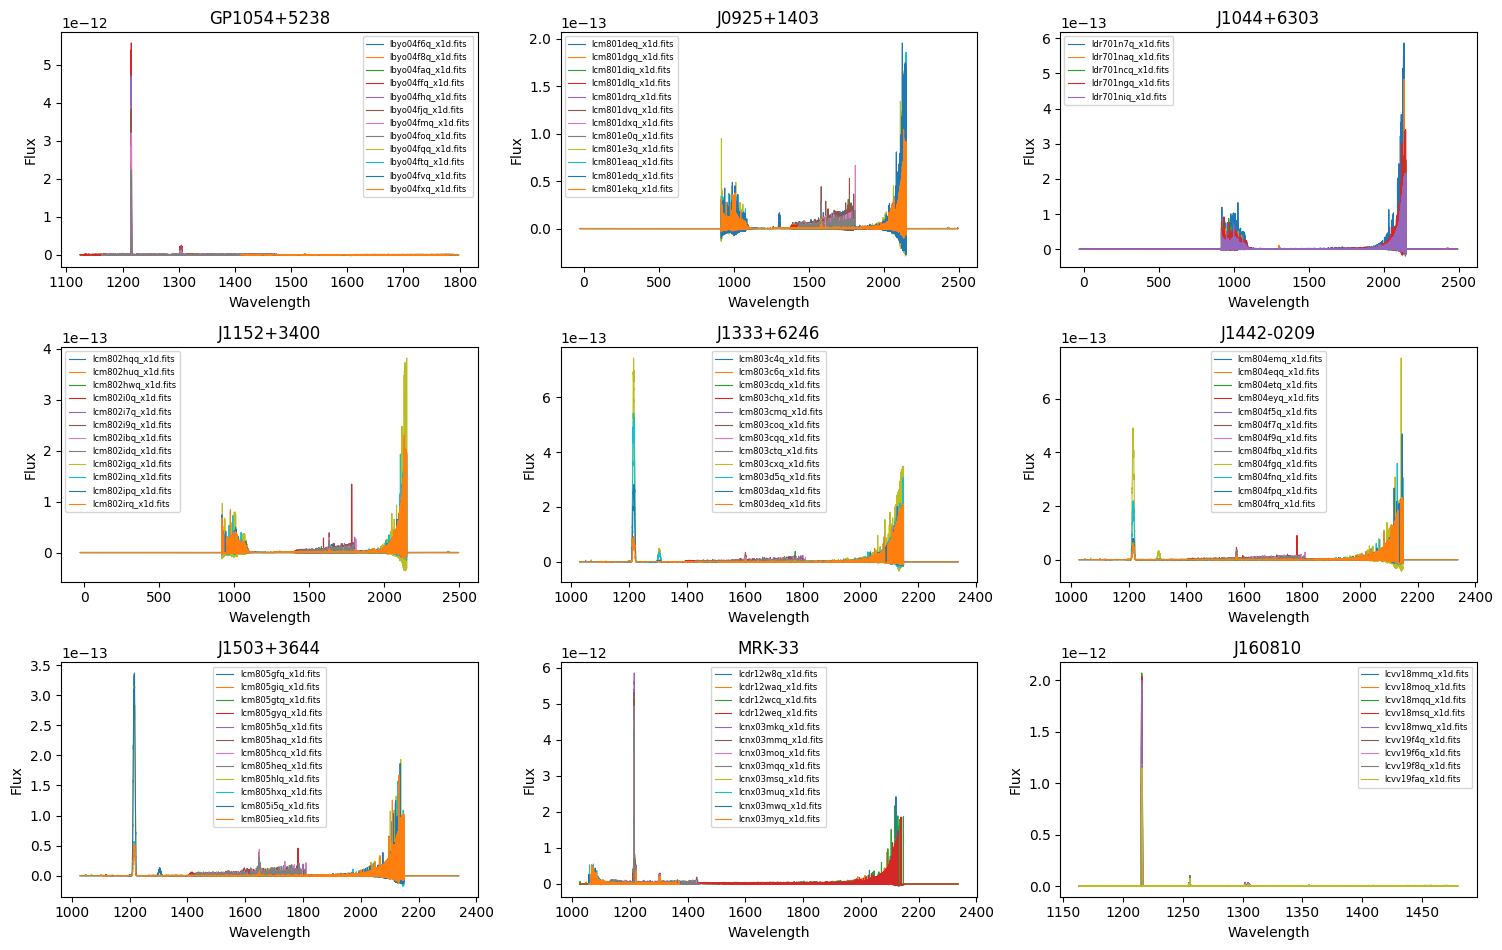

In [24]:
# robust_spectra_inspector.py

import os, glob
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 🚀 Astropy for FITS and spectroscopy
from astropy.table import Table
from astropy.io import fits  

# ====== CONFIGURE THIS ======
root = "GALAXY_DWARF_COMPACT_COS_new"   # <-- set to your folder
plot_first_N_targets = 9                # 0 => no plotting
specific_target = None                  # e.g. "GP1244+0216"
# ============================

print("cwd:", os.getcwd())
print("root exists:", os.path.exists(root))
if not os.path.exists(root):
    raise RuntimeError(f"Root path does not exist: {root!r}. Use an absolute path or check spelling/case.")

# --- Find all FITS files ---
fits_paths = glob.glob(os.path.join(root, "**", "*.[Ff][Ii][Tt][Ss]"), recursive=True)
fits_paths += glob.glob(os.path.join(root, "**", "*.[Ff][Ii][Tt]"), recursive=True)
fits_paths = sorted(set(fits_paths))

print(f"\nFound {len(fits_paths)} FITS files.")
x1d_paths = [p for p in fits_paths if p.lower().endswith("_x1d.fits") or "_x1d." in os.path.basename(p).lower()]
print(f"Found {len(x1d_paths)} '*_x1d.fits' files.")

if len(fits_paths) == 0:
    print("⚠️ No FITS files found. Exiting.")
    exit()

# --- Group by target subfolder ---
groups = defaultdict(list)
for p in fits_paths:
    parts = os.path.normpath(p).split(os.sep)
    try:
        idx = parts.index(os.path.basename(root))
        target = parts[idx + 1]
    except ValueError:
        target = os.path.basename(os.path.dirname(p))
    groups[target].append(p)

# --- Select targets to plot ---
counts = sorted([(t, len(files)) for t, files in groups.items()], key=lambda x: -x[1])
targets_sorted = [t for t, _ in counts]

if specific_target:
    if specific_target not in groups:
        raise RuntimeError(f"specific_target {specific_target!r} not found.")
    targets_to_plot = [specific_target]
else:
    targets_to_plot = targets_sorted[:plot_first_N_targets] if plot_first_N_targets > 0 else []

print("\nTargets to plot:", targets_to_plot)


# --- Spectrum extractor (FIXED) ---
def extract_wave_flux(table):
    names = [c.lower() for c in table.colnames]

    # wavelength-like column
    if any('wave' in n for n in names):
        cname = next(c for c in table.colnames if 'wave' in c.lower())
        wcol = table[cname]
    elif any('lam' in n for n in names):
        cname = next(c for c in table.colnames if 'lam' in c.lower())
        wcol = table[cname]
    else:
        wcol = None

    # flux-like column
    if any(('flux' in n or 'flam' in n or 'f_lambda' in n) for n in names):
        cname = next(c for c in table.colnames 
                     if ('flux' in c.lower() or 'flam' in c.lower() or 'f_lambda' in c.lower()))
        fcol = table[cname]
    else:
        fcol = None

    # fallback if exactly 2 columns → assume wave + flux
    if (wcol is None or fcol is None) and len(table.colnames) == 2:
        wcol, fcol = table[table.colnames[0]], table[table.colnames[1]]

    # Optional debug if nothing found
    if wcol is None or fcol is None:
        print("⚠️ Could not find wave/flux in:", table.colnames)

    return wcol, fcol


# --- Plotting ---
cols = 3
rows = (len(targets_to_plot) + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(cols*5, rows*3.2), squeeze=False)

for ax, target in zip(axes.flatten(), targets_to_plot):
    files = sorted(groups[target])
    plotted = False
    for fpath in files:
        try:
            tbl = Table.read(fpath, format="fits")
        except Exception:
            try:
                hd = fits.open(fpath)
                tbl = None
                for h in hd:
                    if getattr(h, "data", None) is not None and h.data.size > 0:
                        try:
                            tbl = Table(h.data)
                            break
                        except Exception:
                            pass
            except Exception:
                continue
        if tbl is None:
            continue

        wcol, fcol = extract_wave_flux(tbl)
        if wcol is None or fcol is None:
            continue

        wave, flux = np.array(wcol), np.array(fcol)
        mask = (~np.isnan(wave)) & (~np.isnan(flux))
        if mask.sum() < 5:
            continue

        ax.plot(wave[mask], flux[mask], label=os.path.basename(fpath), lw=0.8)
        plotted = True

    if plotted:
        ax.set_title(target)
        ax.set_xlabel("Wavelength")
        ax.set_ylabel("Flux")
        ax.legend(fontsize=6)
    else:
        ax.text(0.5, 0.5, "no plottable spectra", ha="center", va="center")
        ax.set_xticks([]); ax.set_yticks([])

for ax in axes.flatten()[len(targets_to_plot):]:
    ax.axis("off")

plt.tight_layout()
plt.show()
